# Exploration09 - 페렴아 기다려라!

흉부 X-RAY 이미지로 페렴을 진단해보자.

---

### 루브릭 평가 기준

1. 의료 영상을 처리하는 CNN 기반 딥러닝 모델의 구현 - 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였나
2. 데이터 준비, 모델 구성 등의 과정에서 다양한 실험 진행 - regularization, augmentation 등의 기법 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 수행되었나
3. 실습 코드를 잘 개선하여 폐렴 검출 정확도 향상 - Accuracy 기준 85%에 도달하였나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드 및 전처리
  - 데이터 준비
  - 데이터 전처리
  - 데이터 시각화
    

2) 모델 설계 및 훈련
  - 모델 설계
  - 모델 훈련


3) 모델 개선
  - augmentation 적용
  - dropout 제거
  - batch normalization 제거
  - 결과 비교
    
4) 회고

## 0. 필요 모듈 import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 1. 데이터 로드 및 전처리

### - 데이터 준비

캐글의 [Chest X-RAY Images](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays/data)를 이용하여 학습을 진행한다.  
중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5세 소아 환자의 흉부 X선 영상이다.

---

앞으로 사용될 변수 생성를 생성해준다.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.getcwd()
TRAIN_PATH = ROOT_PATH + '/data/train/*/*'
VAL_PATH = ROOT_PATH + '/data/val/*/*'
TEST_PATH = ROOT_PATH + '/data/test/*/*'

# 하이퍼파라미터
INIT_LR = 1e-3  # 초기 학습률 / 학습이 진행될수록 감소시킬 예정
BATCH_SIZE = 32
EPOCHS = 35

위에서 설정한 데이터 경로에서 데이터를 불러온다.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train data는 5216개, test data는 624개, validation data는 16개가 있다.  
validattion data가 너무 부족하기 때문에 train data에서 일부를 가져오도록 한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train data는 4185개, test data는 624개, validation data는 1047개가 있다



정상 이미지와 폐렴 이미지의 라벨은 이미지의 경로로부터 얻을 수 있다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/exploration/ex9_chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/exploration/ex9_chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


파일 경로를 이용하여 정상 이미지와 폐렴 이미지의 개수를 세보자.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


정상 이미지보다 폐렴 이미지가 약 3배 정도 더 많이 있다.  
클래스 별 불균형한 데이터 크기는 CNN 모델의 성능을 하락시킬 수 있다.  
차후에 이를 조정하여 학습에 반영하겠다.


### - 데이터 전처리

tf.data 인스턴스를 만들어 mini-batch로 작업할 수 있도록 한다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


파일 경로로부터 라벨을 얻어내는 함수를 만들어보자.

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지의 사이즈를 통일 시키고 효율적인 학습을 위해 이미지 사이즈를 줄여준다. 

In [10]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

get_lable 함수와 decode_img 함수를 한 번에 처리할 처리해 줄 process_path 함수를 정의하여 사용하도록 하자.


초기에 선언한 AUTOTUNE 변수를 이용하여 빠르게 데이터 처리가 가능하다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지와 라벨이 잘 처리 되었는지 하나만 가져와 확인해본다.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test data와 validation data 처럼 test data도 동일하게 만들어준다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


데이터를 증강시킬 augmentation 기법 도입을 위한 함수를 만든다.  
간단하게 좌우 반전만 포함하도록 한다.

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

tf.data 파이프라인을 이용한 함수를 정의하여 데이터를 변환시킨다.  
- shuffle( ) : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 다음 요소를 선택함
- repeat( ) : epoch을 진행하면서 데이터셋을 여러 번 사용할 수 있도록 함 / 자동으로 데이터를 맞춰줌
- batch( ) : 지정한 배치 크기만큼 나누어줌
- prefetch( ) : 데이터를 학습하는 동안 다음 데이터를 CPU에서 준비하도록 함

augmentation을 적용한 데이터와 적용하지 않은 데이터 두가지를 준비한다.  
추후에 이 두 데이터셋을 이용하여 학습한 결과를 비교해보겠다.

In [15]:
def prepare_for_training(ds, aug=True, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    if aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
        
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# augmentation 적용
train_ds_aug = prepare_for_training(train_ds)
val_ds_aug = prepare_for_training(val_ds)

# augmentation 미적용
train_ds = prepare_for_training(train_ds, False)
val_ds = prepare_for_training(val_ds, False)

### - 데이터 시각화

train data 중 첫 번째 배치를 추출하여 확인해보자.

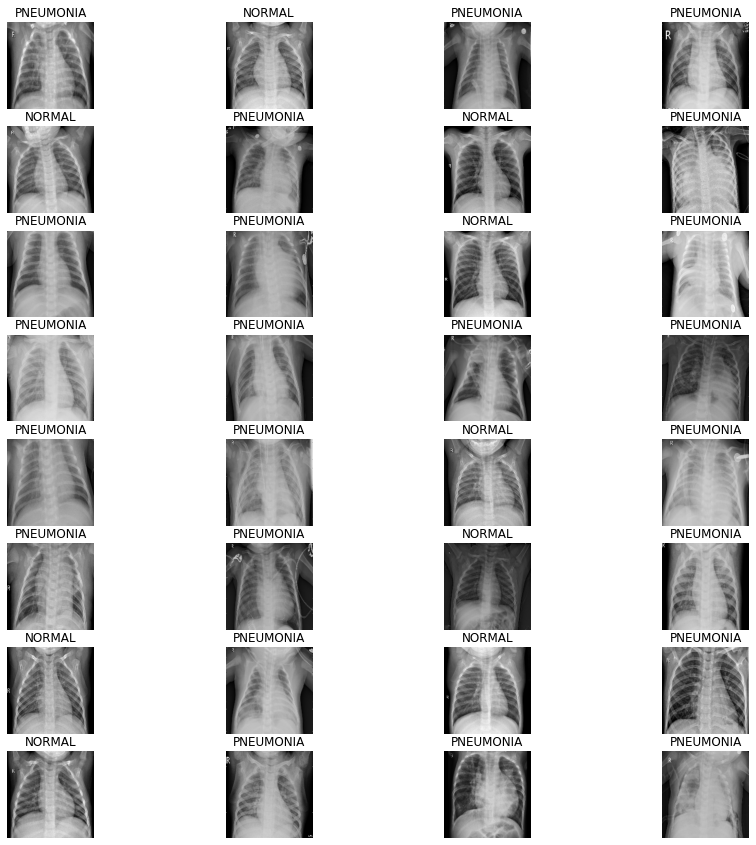

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8,math.ceil(BATCH_SIZE/8),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 2. 모델 설계 및 훈련

### - 모델 설계

이미지에 대한 학습을 진행하기 위해 batch normalization을 포함한 CNN 레이어와 Dense 레이어를 쌓는 함수를 만들어 모델을 설계해보자.

- Convolution block  
Convolution을 두 번 진행하고 Batch Normalization을 한 뒤, 마지막으로 Max Pooling까지 거치도록 한다.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- Dense block  
Fully-Connected 레이어를 하나 거친 뒤 배치 정규화 진행, 마지막으로 dropout을 실시한다.

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

위에서 정의한 두 함수를 이용하여 모델을 쌓는 함수를 만든다.

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
               
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### * Weight balancing으로 데이터 imbalance 처리

Weight balancing은 loss를 계산할 때 특정 클래스의 데이터에 더 큰 가중치를 부여하는 방법이다.  


앞서 음성과 폐렴 데이터의 불균형을 확인했다.  
훈련 과정에서 이를 고려한 가중치를 반영할 수 있도록 class weight를 계산한다.

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


데이터의 수에 반비례하도록 가중치를 세팅한다.

### - 모델 학습

노드에 있는 학습 내용과 동일한 모델로 학습을 진행해보자.  
다만 최적화 함수를 정의할 때 학습이 진행될수록 학습률을 줄여가도록 설정한다.

In [21]:
with tf.device('/GPU:0'):
    model1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    model1.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history1 = model1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
130/130 [==============================] - 61s 367ms/step - loss: 0.4313 - accuracy: 0.7928 - precision: 0.9489 - recall: 0.7623 - val_loss: 0.6084 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/35
130/130 [==============================] - 47s 367ms/step - loss: 0.2662 - accuracy: 0.8889 - precision: 0.9694 - recall: 0.8787 - val_loss: 0.7075 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/35
130/130 [==============================] - 48s 373ms/step - loss: 0.2072 - accuracy: 0.9195 - precision: 0.9735 - recall: 0.9165 - val_loss: 0.9105 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/35
130/130 [==============================] - 49s 382ms/step - loss: 0.1645 - accuracy: 0.9406 - precision: 0.9818 - recall: 0.9378 - val_loss: 1.2782 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/35
130/130 [==============================] - 52s 400ms/step - loss: 0.1597 - accura

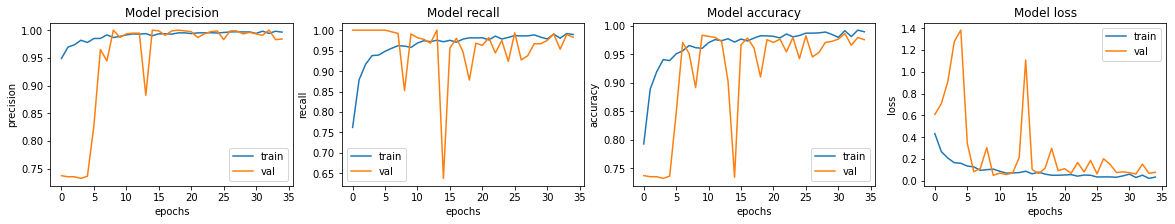

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 229ms/step - loss: 1.4577 - accuracy: 0.7516 - precision: 0.7180 - recall: 0.9923
Loss: 1.4577306509017944,
Accuracy: 0.7516025900840759,
Precision: 0.7179962992668152,
Recall: 0.9923076629638672


테스트 정확도 75%로 루브릭 기준을 충족하지 못한다. •́︿•̀ ｡  
loss 또한 안정적으로 수렴한다고 보기 어렵다.  
다양한 시도들로 모델을 개선해보자.

## 3. 모델 개선

### - augmentation 적용

데이터셋을 만들 때 augmentation을 적용한 데이터셋을 따로 만들어두었다.  
이를 이용하여 학습을 진행해보겠다.  
그 외 모든 조건은 model1과 동일하게 적용한다.

In [25]:
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    model2.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
130/130 [==============================] - 57s 373ms/step - loss: 0.4182 - accuracy: 0.7909 - precision: 0.9546 - recall: 0.7546 - val_loss: 0.5934 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 2/35
130/130 [==============================] - 48s 368ms/step - loss: 0.2421 - accuracy: 0.9036 - precision: 0.9723 - recall: 0.8959 - val_loss: 0.6795 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 3/35
130/130 [==============================] - 48s 368ms/step - loss: 0.1817 - accuracy: 0.9279 - precision: 0.9762 - recall: 0.9258 - val_loss: 0.8664 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/35
130/130 [==============================] - 48s 374ms/step - loss: 0.1736 - accuracy: 0.9305 - precision: 0.9782 - recall: 0.9273 - val_loss: 1.1366 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/35
130/130 [==============================] - 50s 385ms/step - loss: 0.1525 - accura

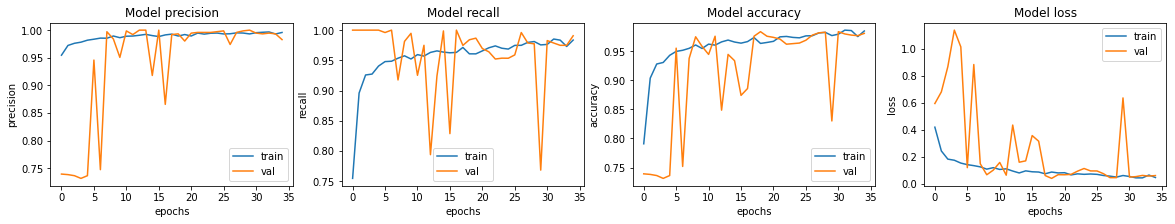

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 219ms/step - loss: 1.4952 - accuracy: 0.7067 - precision: 0.6806 - recall: 1.0000
Loss: 1.495181679725647,
Accuracy: 0.7067307829856873,
Precision: 0.6806282997131348,
Recall: 1.0


테스트 정확도 70.6%로 augmentation을 적용하지 않은 모델보다 성능이 더 좋지 않다.  
이러한 데이터셋에서 크게 도움이 되는 기법은 아닌것 같다.  
이후 시도에서 augmentation은 적용하지 않겠다.

### - dropout 제거

dropout과 batch normalization을 동시에 사용하는 것이 어울리지 않다는 [견해](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)가 있다.  
이번 모델은 모든 dropout을 제거하고 학습을 진행하겠다.

In [29]:
def build_model_without_dropout():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
               
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),       
        conv_block(128),
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0),
        dense_block(128, 0),
        dense_block(64, 0),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [30]:
with tf.device('/GPU:0'):
    model3 = build_model_without_dropout()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    model3.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
130/130 [==============================] - 83s 380ms/step - loss: 0.1923 - accuracy: 0.9228 - precision: 0.9780 - recall: 0.9170 - val_loss: 0.6009 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/35
130/130 [==============================] - 48s 374ms/step - loss: 0.1196 - accuracy: 0.9553 - precision: 0.9869 - recall: 0.9524 - val_loss: 0.7435 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/35
130/130 [==============================] - 49s 376ms/step - loss: 0.1121 - accuracy: 0.9608 - precision: 0.9858 - recall: 0.9613 - val_loss: 1.0374 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/35
130/130 [==============================] - 49s 380ms/step - loss: 0.0732 - accuracy: 0.9738 - precision: 0.9918 - recall: 0.9728 - val_loss: 1.3174 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/35
130/130 [==============================] - 52s 403ms/step - loss: 0.0665 - accura

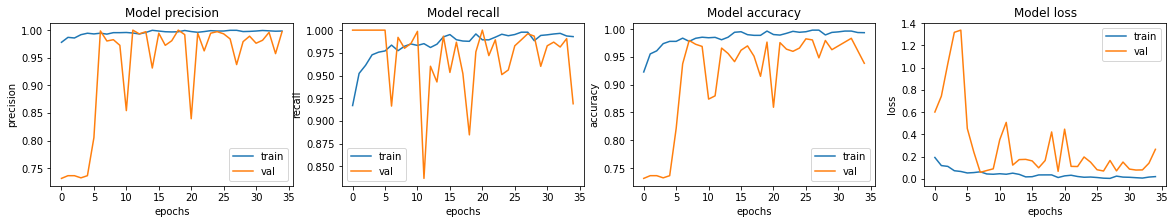

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 224ms/step - loss: 0.7280 - accuracy: 0.8670 - precision: 0.8465 - recall: 0.9615
Loss: 0.7280141115188599,
Accuracy: 0.8669871687889099,
Precision: 0.8465011119842529,
Recall: 0.9615384340286255


#### 드디어 정확도 86% 돌파!!! 루브릭 기준 달성 ٩(๑˃̵ᴗ˂̵)و  

dropout을 제거하는 것이 효과가 있는 것 같다.  
loss도 다른 모델에 비하면 수렴하는 것으로 볼 수 있을 것 같다.

### - batch normalization 제거

이전 과정에서 dropout을 제거했더니 탁월한 성능을 보였다.  
dropout은 유지하고 batch normalization만 제거해도 비슷한 경향을 보일까?

In [34]:
def conv_block_without_batchnorm(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [35]:
def dense_block_without_batchnorm(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [36]:
def build_model_without_batchnorm():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
               
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_without_batchnorm(32),
        conv_block_without_batchnorm(64),
        
        conv_block_without_batchnorm(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_without_batchnorm(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_without_batchnorm(512, 0.7),
        dense_block_without_batchnorm(128, 0.5),
        dense_block_without_batchnorm(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [37]:
with tf.device('/GPU:0'):
    model4 = build_model_without_batchnorm()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    model4.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [38]:
with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
130/130 [==============================] - 83s 371ms/step - loss: 0.6944 - accuracy: 0.4779 - precision: 0.7413 - recall: 0.4563 - val_loss: 0.6962 - val_accuracy: 0.2598 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/35
130/130 [==============================] - 48s 372ms/step - loss: 0.6937 - accuracy: 0.4863 - precision: 0.7371 - recall: 0.4811 - val_loss: 0.7060 - val_accuracy: 0.2676 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/35
130/130 [==============================] - 49s 375ms/step - loss: 0.6937 - accuracy: 0.4212 - precision: 0.7369 - recall: 0.3449 - val_loss: 0.6936 - val_accuracy: 0.2646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/35
130/130 [==============================] - 50s 386ms/step - loss: 0.6914 - accuracy: 0.6233 - precision: 0.7411 - recall: 0.7610 - val_loss: 0.6908 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/35
130/130 [==============================] - 53s 408ms/step

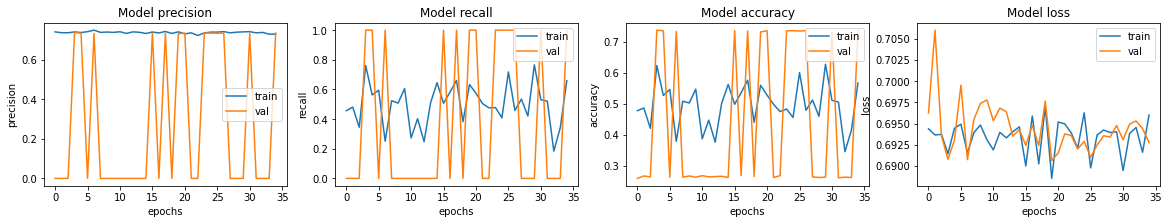

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [40]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 217ms/step - loss: 0.6929 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6929440498352051,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


... 뭔가 잘못된 것 같다 ┏(ﾟロﾟ;)┛  
이미 배치 단위로 나누어져 있는 데이터에 대해서 배치정규화를 하지 않아서 이러한 결과가 나온 것일까?  
배치정규화를 없애는 대신 다른 정규화 방식을 도입했어야 하는걸까?  
많은 의문이 남는다.

### - 결과 비교

총 4개의 모델에 대한 비교를 해보자.

||augmentation|dropout|batch normalization|Accuracy|Precision|Recall|
|---|:---:|:---:|:---:|:---:|:---:|:---:|
|모델1|X|O|O|75.2%|0.718|0.992|
|모델2|O|O|O|70.7%|0.680|1.0|
|모델3|X|X|O|86.7%|0.847|0.962|
|모델4|X|O|X|62.5%|0.625|1.0|


## 5. 회고

#### - 왜 나만 안돼??

이 노드에서 굉장한 어려움을 겪었다.  
NLP 노드보다 더 결과를 내기 힘들었다. 다른분들이 추천해주는 파라미터 아무리 넣어봐도 나만!!! 결과가 안나왔다.   
이를 위해 얼마나 많은 학습을 진행했는지 모르겠다. 사실 이 노트북도 한 번에 완성된게 아니라 며칠에 나누어 겨우 완성할 수 있었다.  
특히 이번 노드는 기존에 공부했던 방식과 다른 방법으로 레이어를 쌓고 한 번도 사용하지 않던 함수? 모듈? 들을 사용하여 무엇을 어떻게 고쳐야 하는 것인지도 잘 몰랐다.  
가장 마지막 모델의 결과가 나의 무지를 보여주고 있다. ˚‧º·(˚ ˃̣̣̥⌓˂̣̣̥ )‧º·˚  


#### - transfer learning

계속해서 결과가 안나와서 이미 검증된 모델의 힘을 빌려 학습을 진행해보았다.  
최종적으로 dropout을 제거한 모델이 기준을 충족했기 때문에 이 노트북에 추가하지는 않았지만 전이학습을 했던 [흔적]()은 남겨두고자 한다.


#### - batch normalization을 안쓰고 싶어요...

dropout을 살리는 대신 batch normalization을 제거하고 싶었는데 시도는 좋았으나 결과가 좋지 못했다.  
이미 배치단위로 나눠놓은 데이터를 사용하기 때문에 배치정규화는 필수인걸까??  
시간이 더 있었다면 이를 해결하면 좋을 것 같다.


#### - 모델 설계

모델 설계를 조금 바꾸면 더 좋은 결과를 낼 수도 있었겠지만 생소한 방식에 시도를 해보지는 못했다.  
노드에서 배웠던 설계 방법 3가지 말고도 이렇게 쌓을 수 있다는 것을 알게되었다.  
다음에 깊고 복잡하고 반복적인 레이어를 쌓는 모델을 만들게 되면 이번 노드에서 사용했던 방식을 사용해봐야겠다.
